In [59]:
import numpy as np

def cos_similarity(v1, v2):
  dot_product = np.dot(v1, v2)
  bottom = (np.sqrt(np.sum(np.square(v1)))) * (np.sqrt(np.sum(np.square(v2))))
  return dot_product / bottom

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = [
            'if you take the blue pill, the story ends',
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes'
]

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(tfidf_vect_simple.get_feature_names())
print(feature_vect_simple.todense().shape)
for mat in feature_vect_simple.todense():
  for item in range(mat.shape[1]):
    if mat[0, item] != 0:
      print(tfidf_vect_simple.get_feature_names()[item], end=" ")
  print()

['blue', 'deep', 'ends', 'goes', 'hole', 'how', 'if', 'in', 'pill', 'rabbit', 'red', 'show', 'stay', 'story', 'take', 'the', 'wonderland', 'you']
(3, 18)
blue ends if pill story take the you 
if in pill red stay take the wonderland you 
deep goes hole how if pill rabbit red show take the you 


In [62]:
feature_vect_dense = feature_vect_simple.todense()

vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
vect2 = np.array(feature_vect_dense[1]).reshape(-1, )
vect3 = np.array(feature_vect_dense[2]).reshape(-1, )

print("Similarity of 1 and 2 :", cos_similarity(vect1, vect2))
print("Similarity of 1 and 3 :", cos_similarity(vect1, vect3))
print("Similarity of 2 and 3 :", cos_similarity(vect2, vect3))

Similarity of 1 and 2 : 0.40207758214950134
Similarity of 1 and 3 : 0.4042504477594862
Similarity of 2 and 3 : 0.45647296026166395


In [67]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


In [68]:
similarity_simple_pair = cosine_similarity(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)
print(similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
(3, 3)


####Opinion Review dataset similarity

In [80]:
import nltk
import string
nltk.download("punkt")
nltk.download("wordnet")

def LemTokens(tokens):
  lemmer = nltk.stem.WordNetLemmatizer()
  return [lemmer.lemmatize(token) for token in tokens]

def LemNormalize(text):
  remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
  return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [74]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

path = '/content/drive/MyDrive/ml-data/Document-clustering'
all_files = glob.glob(os.path.join(path, "*.data"))
filename_list = []
opinion_text = []

for file_ in all_files:
  df = pd.read_table(file_, index_col=None, header=0, encoding="latin1")
  filename_ = file_.split("/")[-1]
  filename = filename_.split(".")[0]
  filename_list.append(filename)
  opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

In [81]:
tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english', ngram_range=(1,2), min_df=0.05, max_df=0.85)
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [83]:
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

In [89]:
from sklearn.metrics.pairwise import cosine_similarity

hotel_indexes = document_df[document_df['cluster_label'] == 0].index
print(hotel_indexes)

comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print("Criteria file : ", comparison_docname)

similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

Int64Index([1, 11, 12, 19, 22, 23, 26, 28, 31, 32, 35, 38, 40, 45, 47], dtype='int64')
Criteria file :  bathroom_bestwestern_hotel_sfo
[[1.         0.06193118 0.05221059 0.05846178 0.0430688  0.06189595
  0.11742762 0.51442299 0.38038865 0.07049362 0.32619948 0.13989623
  0.11282857 0.09518068 0.1386783 ]]


Text(0.5, 1.0, 'bathroom_bestwestern_hotel_sfo')

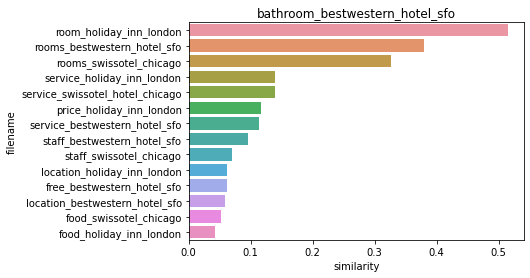

In [93]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sorted_index = similarity_pair.argsort()[:, ::-1]
sorted_index = sorted_index[:,1:]
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(x="similarity", y="filename", data=hotel_1_sim_df)
plt.title(comparison_docname)

In [96]:
other_indexes = document_df[document_df['cluster_label'] == 1].index
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[other_indexes])
print(similarity_pair)

[[0.0077736  0.00792628 0.01041027 0.00621337 0.01177723 0.00813126
  0.00975764 0.00853258 0.01848993 0.00997603 0.00771592 0.0080403
  0.03638665 0.042089   0.01194548 0.02033109 0.00736998 0.01032209
  0.00839468 0.00703369 0.00337714 0.00840026 0.01629369 0.0058994
  0.02011334 0.0132255 ]]


Text(0.5, 1.0, 'bathroom_bestwestern_hotel_sfo')

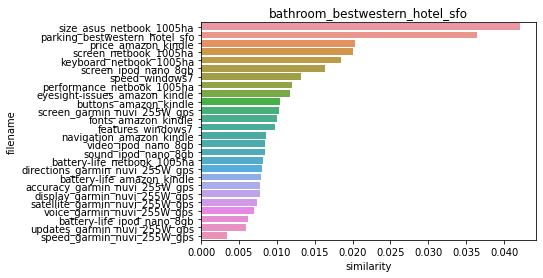

In [100]:
other_sorted_indexes = similarity_pair.argsort()[:, ::-1]
other_sorted_indexes = other_indexes[other_sorted_indexes.reshape(-1)]
other_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]

other_1_sim_df = pd.DataFrame()
other_1_sim_df['filename'] = document_df.iloc[other_sorted_indexes]['filename']
other_1_sim_df['similarity'] = other_1_sim_value

sns.barplot(x="similarity", y="filename", data=other_1_sim_df)
plt.title(comparison_docname)